# We assume that the data set has the following columns 
1. PATIENT_ID
2. DOB_C or (AGE and AGE TYPE(In years or days))
3. GENDER
4. REQ_COMP
5. PBLOODGROUPTESTED
6. TRANSFUSIONINDICATION
7. CLINICAL_DIGNOSIS
8. QTY
9. REQDATETIME
10. REQDATE (Corrected Date format)
11. DOB (Corrected Date format)


## Data Cleaning

In [1]:
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=4a7a3d133d4a00291108bd77ffc62713572323314556c710640748662905fe34
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [2]:
## Import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from datetime import datetime, timezone
import seaborn as sns
import datetime as dt
import pandasql as ps
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams

#from xgboost import XGBRegressor
# import math
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## Import raw file : Already pre-processed in Excel to correct date formats, remove empty rows, correct categories of blood group and blood components;
## User need to ensure basic sanity checks in the input data

excel_file = 'drive/MyDrive/Govt_Data.xlsx'
# excel_file = 'drive/MyDrive/HBB_Req_Issue_DM.xlsx'

# If there are initial empty rows in the data

org_df = pd.read_excel(excel_file, header=None)
org_df = org_df.dropna(how='all').dropna(how='all', axis=1)
headers = org_df.iloc[0]
df  = pd.DataFrame(org_df.values[1:], columns=headers)

## Create a copy

df_reset = df.copy()
# df = df_reset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  if sys.path[0] == '':


In [5]:
df = df_reset

#Drop any empty line in the file
df.dropna(how='all',inplace=True)

#Drop line where request date is NA
df = df[df.REQDATETIME.isna()==False]

#Drop line where Blood Component or Blood Group is NA
df = df[df.Req_Comp.isna()==False]
df = df[df.PBLOODGROUPTESTED.isna()==False]

# Convert QTY column to numeric column
df.QTY = pd.to_numeric(df.QTY, errors ='coerce').fillna(-1).astype('int')
df.replace(to_replace = -1,value = df.QTY.median(),inplace = True)

df.Issue_Qty = pd.to_numeric(df.Issue_Qty, errors ='coerce').fillna(0).astype('int')

# df.QTY<0 or QTY > 1000 then delete as 0/>1K order quantity doesn't make any sense
df = df[df['QTY'] > 0]
df = df[df['QTY'] < 1000]

# Date correction

df['REQDT'] =  pd.to_datetime(df['REQDATE'], format='%Y-%m-%d')
df['REQDT_YR'] =  df['REQDT'].dt.year
df['REQDT_MON'] =  df['REQDT'].dt.month
df["Day_of_Week"] = df.REQDT.dt.weekday
df["week_start"] = df.REQDT - df.Day_of_Week * pd.Timedelta(days=1)


#df['REQDATE'] = pd.to_datetime(df['REQDATE'])
df['DOB'] = pd.to_datetime(df['DOB'])
df['Age'] = df['REQDT'].dt.year-df['DOB'].dt.year

# Remove incomplete dates
#df = df[(df["REQDT"]>="2018-05-01")&(df["REQDT"]<="2022-02-15")]


In [6]:
df

1,Patient_ID,REQDATETIME,DOB_C,GENDER,REQSUBTYPE,PBLOODGROUPTESTED,Req_Comp,QTY,Issue_Date,Issue_Qty,TRANSFUSIONINDICATION,CLINICAL_DIGNOSIS,REQDATE,DOB,REQDT,REQDT_YR,REQDT_MON,Day_of_Week,week_start,Age
0,103381646,2018-01-05 00:14:00,1989-12-08,Female,General,A +ve,PRBC,1,NaN,0,NaN,Others,2018-05-01,1989-12-08,2018-05-01,2018,5,1,2018-04-30,29.0
1,103381646,2018-01-05 00:14:00,1989-12-08,Female,General,A +ve,FFP,6,NaN,0,NaN,Others,2018-05-01,1989-12-08,2018-05-01,2018,5,1,2018-04-30,29.0
2,103713021,2018-01-05 00:16:00,1942-04-28,Male,General,B -ve,PRBC,3,2018-01-05 01:41:00,1,NaN,Others,2018-05-01,1942-04-28,2018-05-01,2018,5,1,2018-04-30,76.0
3,103695766,2018-01-05 00:18:00,2005-04-18,Male,General,O +ve,PRBC,2,2018-01-05 01:30:00,1,NaN,Others,2018-05-01,2005-04-18,2018-05-01,2018,5,1,2018-04-30,13.0
4,102549125,2018-01-05 00:26:00,2015-05-01,Male,General,AB +ve,PRBC,1,2018-01-05 00:30:00,1,NaN,Others,2018-05-01,2015-05-01,2018-05-01,2018,5,1,2018-04-30,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355083,500300241,16/02/2022 10:34,1971-02-02,Male,General,B +ve,PRBC,2,NaN,0,# IT POLYTRAUMA PATIENT,H/O POLYTRAUMA,2022-02-16,1971-02-02,2022-02-16,2022,2,2,2022-02-14,51.0
355084,500301150,16/02/2022 10:35,1992-02-11,Male,General,B +ve,PRBC,2,NaN,0,polytrauma,POLYTRAUMA,2022-02-16,1992-02-11,2022-02-16,2022,2,2,2022-02-14,30.0
355085,105519735,16/02/2022 10:35,1970-08-13,Female,General,B -ve,PRBC,1,NaN,0,anemia,NaN,2022-02-16,1970-08-13,2022-02-16,2022,2,2,2022-02-14,52.0
355086,105776139,16/02/2022 10:36,2007-01-13,Male,General,AB +ve,PRBC,1,NaN,0,anemia bleeding,aa,2022-02-16,2007-01-13,2022-02-16,2022,2,2,2022-02-14,15.0


In [7]:
df_f = ps.sqldf("""

with df1 as (
select 
PBLOODGROUPTESTED,
Req_Comp,
DATE(REQDT) as REQDT,

sum(QTY) as n_qty_n1d,
sum(Issue_Qty) as n_issue_qty_n1d,

max(case when Day_of_Week = 0 then 1 else 0 end) as ind_dow0,
max(case when Day_of_Week = 1 then 1 else 0 end) as ind_dow1,
max(case when Day_of_Week = 2 then 1 else 0 end) as ind_dow2,
max(case when Day_of_Week = 3 then 1 else 0 end) as ind_dow3,
max(case when Day_of_Week = 4 then 1 else 0 end) as ind_dow4,
max(case when Day_of_Week = 5 then 1 else 0 end) as ind_dow5,
max(case when Day_of_Week = 6 then 1 else 0 end) as ind_dow6,

sum(case when GENDER = "Female" then QTY else 0 end) as n_qty_fem_n1d,
sum(case when REQSUBTYPE = "Neonate" then QTY else 0 end) as n_qty_neo_n1d,
sum(case when TRANSFUSIONINDICATION = "anemia" then QTY else 0 end) as n_qty_anm_n1d,
sum(case when Age > 50 then QTY else 0 end) as n_qty_agegt50_n1d,
sum(case when Age < 10 then QTY else 0 end) as n_qty_agelt10_n1d

from df 
group by 1,2,3),

df2 as (
select 
a.PBLOODGROUPTESTED,
a.Req_Comp,
DATE(a.REQDT) as REQDT,

sum(case when DATE(b.REQDT) >= DATE(a.REQDT) and DATE(b.REQDT) < DATE(a.REQDT,'7 DAYS') then b.n_qty_n1d else 0 end) as n_qty_n7d,

sum(case when DATE(b.REQDT) >= DATE(a.REQDT) and DATE(b.REQDT) < DATE(a.REQDT,'21 DAYS') then b.n_qty_n1d else 0 end) as n_qty_n21d,

sum(case when DATE(b.REQDT) >= DATE(a.REQDT) and DATE(b.REQDT) < DATE(a.REQDT,'7 DAYS') then b.n_issue_qty_n1d else 0 end) as n_issue_qty_n7d,

sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l1d,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-7 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l7thd,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-14 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l14thd,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-21 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l21thd,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-28 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l28thd,
sum(case when DATE(b.REQDT) < DATE(a.REQDT) and DATE(b.REQDT) >= DATE(a.REQDT,'-7 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l7d,
sum(case when DATE(b.REQDT) < DATE(a.REQDT) and DATE(b.REQDT) >= DATE(a.REQDT,'-28 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l28d,

sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_fem_n1d else 0 end) as n_qty_fem_l1d,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_neo_n1d else 0 end) as n_qty_neo_l1d,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_anm_n1d else 0 end) as n_qty_anm_l1d,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_agegt50_n1d else 0 end) as n_qty_agegt50_l1d,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_agelt10_n1d else 0 end) as n_qty_agelt10_l1d,

1.0 * sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_fem_n1d else 0 end)/ sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_n1d else 0 end) as p_qty_fem_l1d,
1.0 * sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_neo_n1d else 0 end)/ sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_n1d else 0 end) as p_qty_neo_l1d,
1.0 * sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_anm_n1d else 0 end)/ sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_n1d else 0 end) as p_qty_anm_l1d,
1.0 * sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_agegt50_n1d else 0 end)/ sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_n1d else 0 end) as p_qty_agegt50_l1d,
1.0 * sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_agelt10_n1d else 0 end)/ sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_n1d else 0 end) as p_qty_agelt10_l1d

from df1 a
left join df1 b
on a.Req_Comp = b.Req_Comp and a.PBLOODGROUPTESTED = b.PBLOODGROUPTESTED
where DATE(b.REQDT) < DATE(a.REQDT,'7 DAYS') and DATE(b.REQDT) >= DATE(a.REQDT,'-28 DAYS')

group by 1,2,3),

df3 as (
select
a.Req_Comp,
DATE(a.REQDT) as REQDT,

sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-1 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l1d_Req_Comp,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-7 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l7thd_Req_Comp,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-14 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l14thd_Req_Comp,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-21 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l21thd_Req_Comp,
sum(case when DATE(b.REQDT) = DATE(a.REQDT,'-28 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l28thd_Req_Comp,
sum(case when DATE(b.REQDT) < DATE(a.REQDT) and DATE(b.REQDT) >= DATE(a.REQDT,'-7 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l7d_Req_Comp,
sum(case when DATE(b.REQDT) < DATE(a.REQDT) and DATE(b.REQDT) >= DATE(a.REQDT,'-28 DAYS') then b.n_qty_n1d else 0 end) as n_qty_l28d_Req_Comp

from df1 a
left join df1 b
on a.Req_Comp = b.Req_Comp
where DATE(b.REQDT) < DATE(a.REQDT) and DATE(b.REQDT) >= DATE(a.REQDT,'-28 DAYS')
group by 1,2)

select 
df1.PBLOODGROUPTESTED,
df1.Req_Comp,
df1.REQDT,
df1.ind_dow0,
df1.ind_dow1,
df1.ind_dow2,
df1.ind_dow3,
df1.ind_dow4,
df1.ind_dow5,
df1.ind_dow6,

coalesce(df1.n_qty_n1d,0) as n_qty_n1d,
coalesce(df1.n_issue_qty_n1d,0) as n_issue_qty_n1d,

coalesce(df2.n_qty_n7d,0) as n_qty_n7d,
coalesce(df2.n_issue_qty_n7d,0) as n_issue_qty_n7d,

coalesce(df2.n_qty_n21d,0) as n_qty_n21d,

coalesce(df2.n_qty_l1d,0) as n_qty_l1d,
coalesce(df2.n_qty_l7thd,0) as n_qty_l7thd,
coalesce(df2.n_qty_l14thd,0) as n_qty_l14thd,
coalesce(df2.n_qty_l21thd,0) as n_qty_l21thd,
coalesce(df2.n_qty_l28thd,0) as n_qty_l28thd,


coalesce(df2.n_qty_l7d,0) as n_qty_l7d,
coalesce(df2.n_qty_l28d,0) as n_qty_l28d,

coalesce(df2.p_qty_fem_l1d,0) as p_qty_fem_l1d,
coalesce(df2.p_qty_neo_l1d,0) as p_qty_neo_l1d,
coalesce(df2.p_qty_anm_l1d,0) as p_qty_anm_l1d,
coalesce(df2.p_qty_agegt50_l1d,0) as p_qty_agegt50_l1d,
coalesce(df2.p_qty_agelt10_l1d,0) as p_qty_agelt10_l1d,

coalesce(df3.n_qty_l1d_Req_Comp,0) as n_qty_l1d_Req_Comp,
coalesce(df3.n_qty_l7thd_Req_Comp,0) as n_qty_l7thd_Req_Comp,
coalesce(df3.n_qty_l14thd_Req_Comp,0) as n_qty_l14thd_Req_Comp,
coalesce(df3.n_qty_l21thd_Req_Comp,0) as n_qty_l21thd_Req_Comp,
coalesce(df3.n_qty_l28thd_Req_Comp,0) as n_qty_l28thd_Req_Comp,
coalesce(df3.n_qty_l7d_Req_Comp,0) as n_qty_l7d_Req_Comp,
coalesce(df3.n_qty_l28d_Req_Comp,0) as n_qty_l28d_Req_Comp

from df1
left join df2 on df1.Req_Comp = df2.Req_Comp and DATE(df1.REQDT) = DATE(df2.REQDT) and df1.PBLOODGROUPTESTED = df2.PBLOODGROUPTESTED
left join df3 on df1.Req_Comp = df3.Req_Comp and DATE(df1.REQDT) = DATE(df3.REQDT)

""")

In [ ]:
# import matplotlib.ticker as ticker
# import matplotlib.cm as cm
# import matplotlib as mpl
# from matplotlib.gridspec import GridSpec
# import matplotlib.pyplot as plt

# type_labels = df_final.groupby('Req_Comp').sum().n_qty_l1d.sort_values().index 
# type_counts = df_final.groupby('Req_Comp').sum().n_qty_l1d.sort_values()

# plt.figure(1, figsize=(15,10)) 
# the_grid = GridSpec(2, 2)

# cmap = plt.get_cmap('Spectral')
# colors = [cmap(i) for i in np.linspace(0, 1, 8)]

# plt.subplot(the_grid[0, 1], aspect=1, title='GOVT ratio of Blood components')
# type_show_ids = plt.pie(type_counts, labels=type_labels, autopct='%1.1f%%', shadow=True, colors=colors)
# plt.show()

In [8]:
df_f['REQDT_DTM'] = pd.to_datetime(df['REQDT'])
df_f['ind_holiday'] = 0
df_f.loc[(df_f.REQDT_DTM.dt.month == 1) & (df_f.REQDT_DTM.dt.day == 26), 'ind_holiday'] = 1
df_f.loc[(df_f.REQDT_DTM.dt.month == 8) & (df_f.REQDT_DTM.dt.day == 15), 'ind_holiday'] = 1
df_f.loc[(df_f.REQDT_DTM.dt.month == 10) & (df_f.REQDT_DTM.dt.day == 2), 'ind_holiday'] = 1

## Remove the incomplete time period [At least has last 28 days / next 7 days data]

df_f1 = df_f[(df_f['REQDT']<"2022-02-10")&(df_f['REQDT']>="2018-06-01")]

## Remove 2019 & 2020

df_final = df_f1[(df_f1['REQDT']<"2019-03-15")|(df_f1['REQDT']>="2020-11-15")]

In [9]:
df_final[df_final['REQDT']>="2021-04-01"].describe()

,ind_dow0,ind_dow1,ind_dow2,ind_dow3,ind_dow4,ind_dow5,ind_dow6,n_qty_n1d,n_issue_qty_n1d,n_qty_n7d,...,p_qty_agegt50_l1d,p_qty_agelt10_l1d,n_qty_l1d_Req_Comp,n_qty_l7thd_Req_Comp,n_qty_l14thd_Req_Comp,n_qty_l21thd_Req_Comp,n_qty_l28thd_Req_Comp,n_qty_l7d_Req_Comp,n_qty_l28d_Req_Comp,ind_holiday
count,6896.000000,6896.000000,6896.000000,6896.000000,6896.000000,6896.000000,6896.000000,6896.000000,6896.000000,6896.000000,...,6896.000000,6896.000000,6896.000000,6896.000000,6896.000000,6896.000000,6896.000000,6896.000000,6896.000000,6896.0
mean,0.147912,0.148202,0.147767,0.141241,0.146027,0.144722,0.124130,32.766241,11.777842,225.396752,...,0.165095,0.088152,1386.119635,1395.889791,1403.313515,1405.578451,1414.578451,9704.141096,38965.093532,0.0
std,0.355038,0.355326,0.354894,0.348296,0.353159,0.351845,0.329754,37.802067,14.222145,252.836691,...,0.220733,0.178755,911.845469,925.833680,930.936015,924.112260,929.848027,6069.170430,23956.617329,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,21.000000,...,0.000000,0.000000,693.000000,688.500000,666.000000,690.000000,672.000000,5208.500000,21105.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,5.000000,110.000000,...,0.100000,0.000000,1400.000000,1386.000000,1416.000000,1426.000000,1435.000000,10074.000000,40761.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.000000,18.000000,395.000000,...,0.250000,0.105263,2072.000000,2088.000000,2105.000000,2112.000000,2112.000000,14592.000000,58376.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,257.000000,76.000000,1186.000000,...,1.000000,1.000000,4032.000000,4112.000000,4608.000000,4048.000000,3800.000000,24816.000000,93408.000000,0.0


In [10]:
df_final.columns

Index(['PBLOODGROUPTESTED', 'Req_Comp', 'REQDT', 'ind_dow0', 'ind_dow1',
       'ind_dow2', 'ind_dow3', 'ind_dow4', 'ind_dow5', 'ind_dow6', 'n_qty_n1d',
       'n_issue_qty_n1d', 'n_qty_n7d', 'n_issue_qty_n7d', 'n_qty_n21d',
       'n_qty_l1d', 'n_qty_l7thd', 'n_qty_l14thd', 'n_qty_l21thd',
       'n_qty_l28thd', 'n_qty_l7d', 'n_qty_l28d', 'p_qty_fem_l1d',
       'p_qty_neo_l1d', 'p_qty_anm_l1d', 'p_qty_agegt50_l1d',
       'p_qty_agelt10_l1d', 'n_qty_l1d_Req_Comp', 'n_qty_l7thd_Req_Comp',
       'n_qty_l14thd_Req_Comp', 'n_qty_l21thd_Req_Comp',
       'n_qty_l28thd_Req_Comp', 'n_qty_l7d_Req_Comp', 'n_qty_l28d_Req_Comp',
       'REQDT_DTM', 'ind_holiday'],
      dtype='object')

In [11]:
def my_model_1d(bc,bg):
    
    df_model = df_final[(df_final["Req_Comp"]==bc)&(df_final["PBLOODGROUPTESTED"]==bg)]
    
    features = ['n_qty_l1d','n_qty_l7thd','n_qty_l14thd','n_qty_l21thd','n_qty_l28thd','n_qty_l7d','n_qty_l28d',
                'ind_dow0','ind_dow1','ind_dow2','ind_dow3','ind_dow4','ind_dow5','ind_dow6','ind_holiday',
                'n_qty_l1d_Req_Comp','n_qty_l7thd_Req_Comp','n_qty_l14thd_Req_Comp','n_qty_l21thd_Req_Comp',
                'n_qty_l28thd_Req_Comp','n_qty_l7d_Req_Comp','n_qty_l28d_Req_Comp',
                'p_qty_fem_l1d','p_qty_agelt10_l1d','p_qty_anm_l1d','p_qty_neo_l1d']
    label = 'n_qty_n1d'

    train_df = df_model[df_model['REQDT']<"2021-04-01"]
    test_df = df_model[df_model['REQDT']>="2021-04-01"]

    X_train, y_train = train_df[features],train_df[label]
    X_test, y_test = test_df[features],test_df[label]

#     lm = LinearRegression()
#     model = lm.fit(X_train, y_train)
    
    model = XGBRegressor(n_estimators=500, learning_rate=0.01)
    model.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae',verbose = False)
    y_pred = model.predict(X_test)

#     y_pred = model.predict(X_test)
    test_df = test_df.reset_index().drop('index',axis =1)
    test_df['predictions_1d'] = pd.Series(y_pred)

    from sklearn.metrics import r2_score
    r2 = r2_score(y_test,y_pred)
    print(r2)

    X_all, y_all = df_model[features],df_model[label]
    y_pred_all = model.predict(X_all)
    df_m = df_model.reset_index().drop('index',axis =1)
    df_m['predictions_1d'] = pd.Series(y_pred_all)

#     df_m["actual_supply_gap"] = df_m["n_qty_n1d"] - df_m["n_issue_qty_n1d"]
#     df_m["exp_supply_gap"] = (df_m["n_qty_n1d"] - df_m["n_issue_qty_n1d"])/df_m["n_qty_n1d"]
    

    
#     plt.rcParams.update({'figure.figsize': (15, 5), 'figure.dpi':300})
#     fig, ax = plt.subplots()
#     sns.lineplot(data=df_m.tail(200), x='REQDT', y='n_qty_n1d',label="Actual 1d")
#     sns.lineplot(data=df_m.tail(200), x='REQDT', y='predictions_1d',label="Predicted 1d")
#     #sns.lineplot(data=df_m.tail(40), x='REQDT', y='n_issue_qty_n1d',label="Issued 1d")
    
# #     sns.lineplot(data=df_m.tail(42), x='REQDT', y='actual_supply_gap',label="Act_gap")
# #     sns.lineplot(data=df_m.tail(42), x='REQDT', y='exp_supply_gap',label="Exp_gap")
    
#     plt.grid(linestyle='-', linewidth=0.5)
#     ax.tick_params(axis='x', rotation=90)

#     plt.xlabel('Date')
#     plt.ylabel('Qty')
#     plt.title("Predicted vs. Actual Qty : " + bc + "  ")
    return y_pred_all,X_all

In [12]:
def my_model_7d(bc,bg):
    
    df_model = df_final[(df_final["Req_Comp"]==bc)&(df_final["PBLOODGROUPTESTED"]==bg)]
    
    features = ['n_qty_l1d','n_qty_l7thd','n_qty_l14thd','n_qty_l21thd','n_qty_l28thd','n_qty_l7d','n_qty_l28d',
                'ind_dow0','ind_dow1','ind_dow2','ind_dow3','ind_dow4','ind_dow5','ind_dow6','ind_holiday',
                'n_qty_l1d_Req_Comp','n_qty_l7thd_Req_Comp','n_qty_l14thd_Req_Comp','n_qty_l21thd_Req_Comp',
                'n_qty_l28thd_Req_Comp','n_qty_l7d_Req_Comp','n_qty_l28d_Req_Comp',
                'p_qty_fem_l1d','p_qty_agelt10_l1d','p_qty_anm_l1d','p_qty_neo_l1d']
    label = 'n_qty_n7d'

    train_df = df_model[df_model['REQDT']<"2021-04-01"]
    test_df = df_model[df_model['REQDT']>="2021-04-01"]

    X_train, y_train = train_df[features],train_df[label]
    X_test, y_test = test_df[features],test_df[label]

#     lm = LinearRegression()
#     model = lm.fit(X_train, y_train)
    
    model = XGBRegressor(n_estimators=500, learning_rate=0.01)
    model.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae',verbose=False)
    y_pred = model.predict(X_test)

#     y_pred = model.predict(X_test)
    test_df = test_df.reset_index().drop('index',axis =1)
    test_df['predictions_7d'] = pd.Series(y_pred)

    from sklearn.metrics import r2_score
    r2 = r2_score(y_test,y_pred)
    print(r2)

    X_all, y_all = df_model[features],df_model[label]
    
    y_pred_all = model.predict(X_all)
    
    df_m = df_model.reset_index().drop('index',axis =1)
    df_m['predictions_7d'] = pd.Series(y_pred_all)

    
    # plt.rcParams.update({'figure.figsize': (15, 5), 'figure.dpi':300})
    # fig, ax = plt.subplots()
    # sns.lineplot(data=df_m.tail(41), x='REQDT', y='n_qty_n7d',label="Actual 7d")
    # sns.lineplot(data=df_m.tail(41), x='REQDT', y='predictions_7d',label="Predicted 7d")
    
    # plt.grid(linestyle='-', linewidth=0.5)
    # ax.tick_params(axis='x', rotation=90)

    # plt.xlabel('Date')
    # plt.ylabel('Qty')
    # plt.title("Predicted vs. Actual Qty : " + bc + "  " + bg)
    return y_pred_all,X_all

In [13]:
def my_model_21d(bc,bg):
    
    df_model = df_final[(df_final["Req_Comp"]==bc)&(df_final["PBLOODGROUPTESTED"]==bg)]
    
    features = ['n_qty_l1d','n_qty_l7thd','n_qty_l14thd','n_qty_l21thd','n_qty_l28thd','n_qty_l7d','n_qty_l28d',
                'ind_dow0','ind_dow1','ind_dow2','ind_dow3','ind_dow4','ind_dow5','ind_dow6','ind_holiday',
                'n_qty_l1d_Req_Comp','n_qty_l7thd_Req_Comp','n_qty_l14thd_Req_Comp','n_qty_l21thd_Req_Comp',
                'n_qty_l28thd_Req_Comp','n_qty_l7d_Req_Comp','n_qty_l28d_Req_Comp',
                'p_qty_fem_l1d','p_qty_agelt10_l1d','p_qty_anm_l1d','p_qty_neo_l1d']
    label = 'n_qty_n21d'

    train_df = df_model[df_model['REQDT']<"2021-04-01"]
    test_df = df_model[df_model['REQDT']>="2021-04-01"]

    X_train, y_train = train_df[features],train_df[label]
    X_test, y_test = test_df[features],test_df[label]

#     lm = LinearRegression()
#     model = lm.fit(X_train, y_train)
    
    model = XGBRegressor(n_estimators=500, learning_rate=0.01)
    model.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae',verbose = True)
    y_pred = model.predict(X_test)

#     y_pred = model.predict(X_test)
    test_df = test_df.reset_index().drop('index',axis =1)
    test_df['predictions_1d'] = pd.Series(y_pred)

    from sklearn.metrics import r2_score
    r2 = r2_score(y_test,y_pred)
    print(r2)

    X_all, y_all = df_model[features],df_model[label]
    y_pred_all = model.predict(X_all)
    df_m = df_model.reset_index().drop('index',axis =1)
    df_m['predictions_1d'] = pd.Series(y_pred_all)

    # df_m["actual_supply_gap"] = df_m["n_qty_n1d"] - df_m["n_issue_qty_n1d"]
    # df_m["exp_supply_gap"] = (df_m["n_qty_n1d"] - df_m["n_issue_qty_n1d"])/df_m["n_qty_n1d"]
    

    
    plt.rcParams.update({'figure.figsize': (15, 5), 'figure.dpi':300})
    fig, ax = plt.subplots()
    sns.lineplot(data=df_m.tail(200), x='REQDT', y='n_qty_n21d',label="Actual 1d")
    sns.lineplot(data=df_m.tail(200), x='REQDT', y='predictions_1d',label="Predicted 1d")
    #sns.lineplot(data=df_m.tail(40), x='REQDT', y='n_issue_qty_n1d',label="Issued 1d")
    
#     sns.lineplot(data=df_m.tail(42), x='REQDT', y='actual_supply_gap',label="Act_gap")
#     sns.lineplot(data=df_m.tail(42), x='REQDT', y='exp_supply_gap',label="Exp_gap")
    
    plt.grid(linestyle='-', linewidth=0.5)
    ax.tick_params(axis='x', rotation=90)

    plt.xlabel('Date')
    plt.ylabel('Qty')
    plt.title("Predicted vs. Actual Qty : " + bc + "  ")
    return model.predict(X_all.iloc[-1:,:])

In [24]:
df_final

,PBLOODGROUPTESTED,Req_Comp,REQDT,ind_dow0,ind_dow1,ind_dow2,ind_dow3,ind_dow4,ind_dow5,ind_dow6,...,p_qty_agelt10_l1d,n_qty_l1d_Req_Comp,n_qty_l7thd_Req_Comp,n_qty_l14thd_Req_Comp,n_qty_l21thd_Req_Comp,n_qty_l28thd_Req_Comp,n_qty_l7d_Req_Comp,n_qty_l28d_Req_Comp,REQDT_DTM,ind_holiday
15,A +ve,BUFFY COAT,2018-06-01,0,0,0,0,1,0,0,...,0.0,11,4,0,12,8,41,197,2018-05-01,0
16,A +ve,BUFFY COAT,2018-06-13,0,0,1,0,0,0,0,...,0.0,10,8,5,6,8,50,126,2018-05-01,0
17,A +ve,BUFFY COAT,2018-06-15,0,0,0,0,1,0,0,...,0.0,33,24,12,12,0,141,372,2018-05-01,0
18,A +ve,BUFFY COAT,2018-06-26,0,1,0,0,0,0,0,...,0.0,8,8,20,8,10,82,324,2018-05-01,0
19,A +ve,BUFFY COAT,2018-07-13,0,0,0,0,1,0,0,...,0.0,0,4,4,13,22,14,133,2018-05-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30685,O -ve,SDP,2022-01-19,0,0,1,0,0,0,0,...,0.0,14,12,14,34,22,72,436,2018-08-21,0
30686,O -ve,SDP,2022-01-26,0,0,1,0,0,0,0,...,0.0,16,4,12,14,34,66,368,2018-08-21,0
30687,O -ve,SDP,2022-01-30,0,0,0,0,0,0,1,...,0.0,16,0,16,4,24,128,604,2018-08-21,0
30688,O -ve,SDP,2022-02-03,0,0,0,1,0,0,0,...,0.0,21,18,18,18,27,114,435,2018-08-21,0


[13:46:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:785.253	validation_1-mae:737.9
[1]	validation_0-mae:777.434	validation_1-mae:730.288
[2]	validation_0-mae:769.706	validation_1-mae:722.802
[3]	validation_0-mae:762.055	validation_1-mae:715.386
[4]	validation_0-mae:754.479	validation_1-mae:708.05
[5]	validation_0-mae:746.98	validation_1-mae:700.785
[6]	validation_0-mae:739.554	validation_1-mae:693.59
[7]	validation_0-mae:732.203	validation_1-mae:686.467
[8]	validation_0-mae:724.946	validation_1-mae:679.233
[9]	validation_0-mae:717.759	validation_1-mae:672.066
[10]	validation_0-mae:710.646	validation_1-mae:664.974
[11]	validation_0-mae:703.6	validation_1-mae:657.947
[12]	validation_0-mae:696.626	validation_1-mae:650.992
[13]	validation_0-mae:689.721	validation_1-mae:644.107
[14]	validation_0-mae:682.884	validation_1-mae:637.288
[15]	validation_0-mae:676.116	validation_1-mae:630.539
[16]	valid

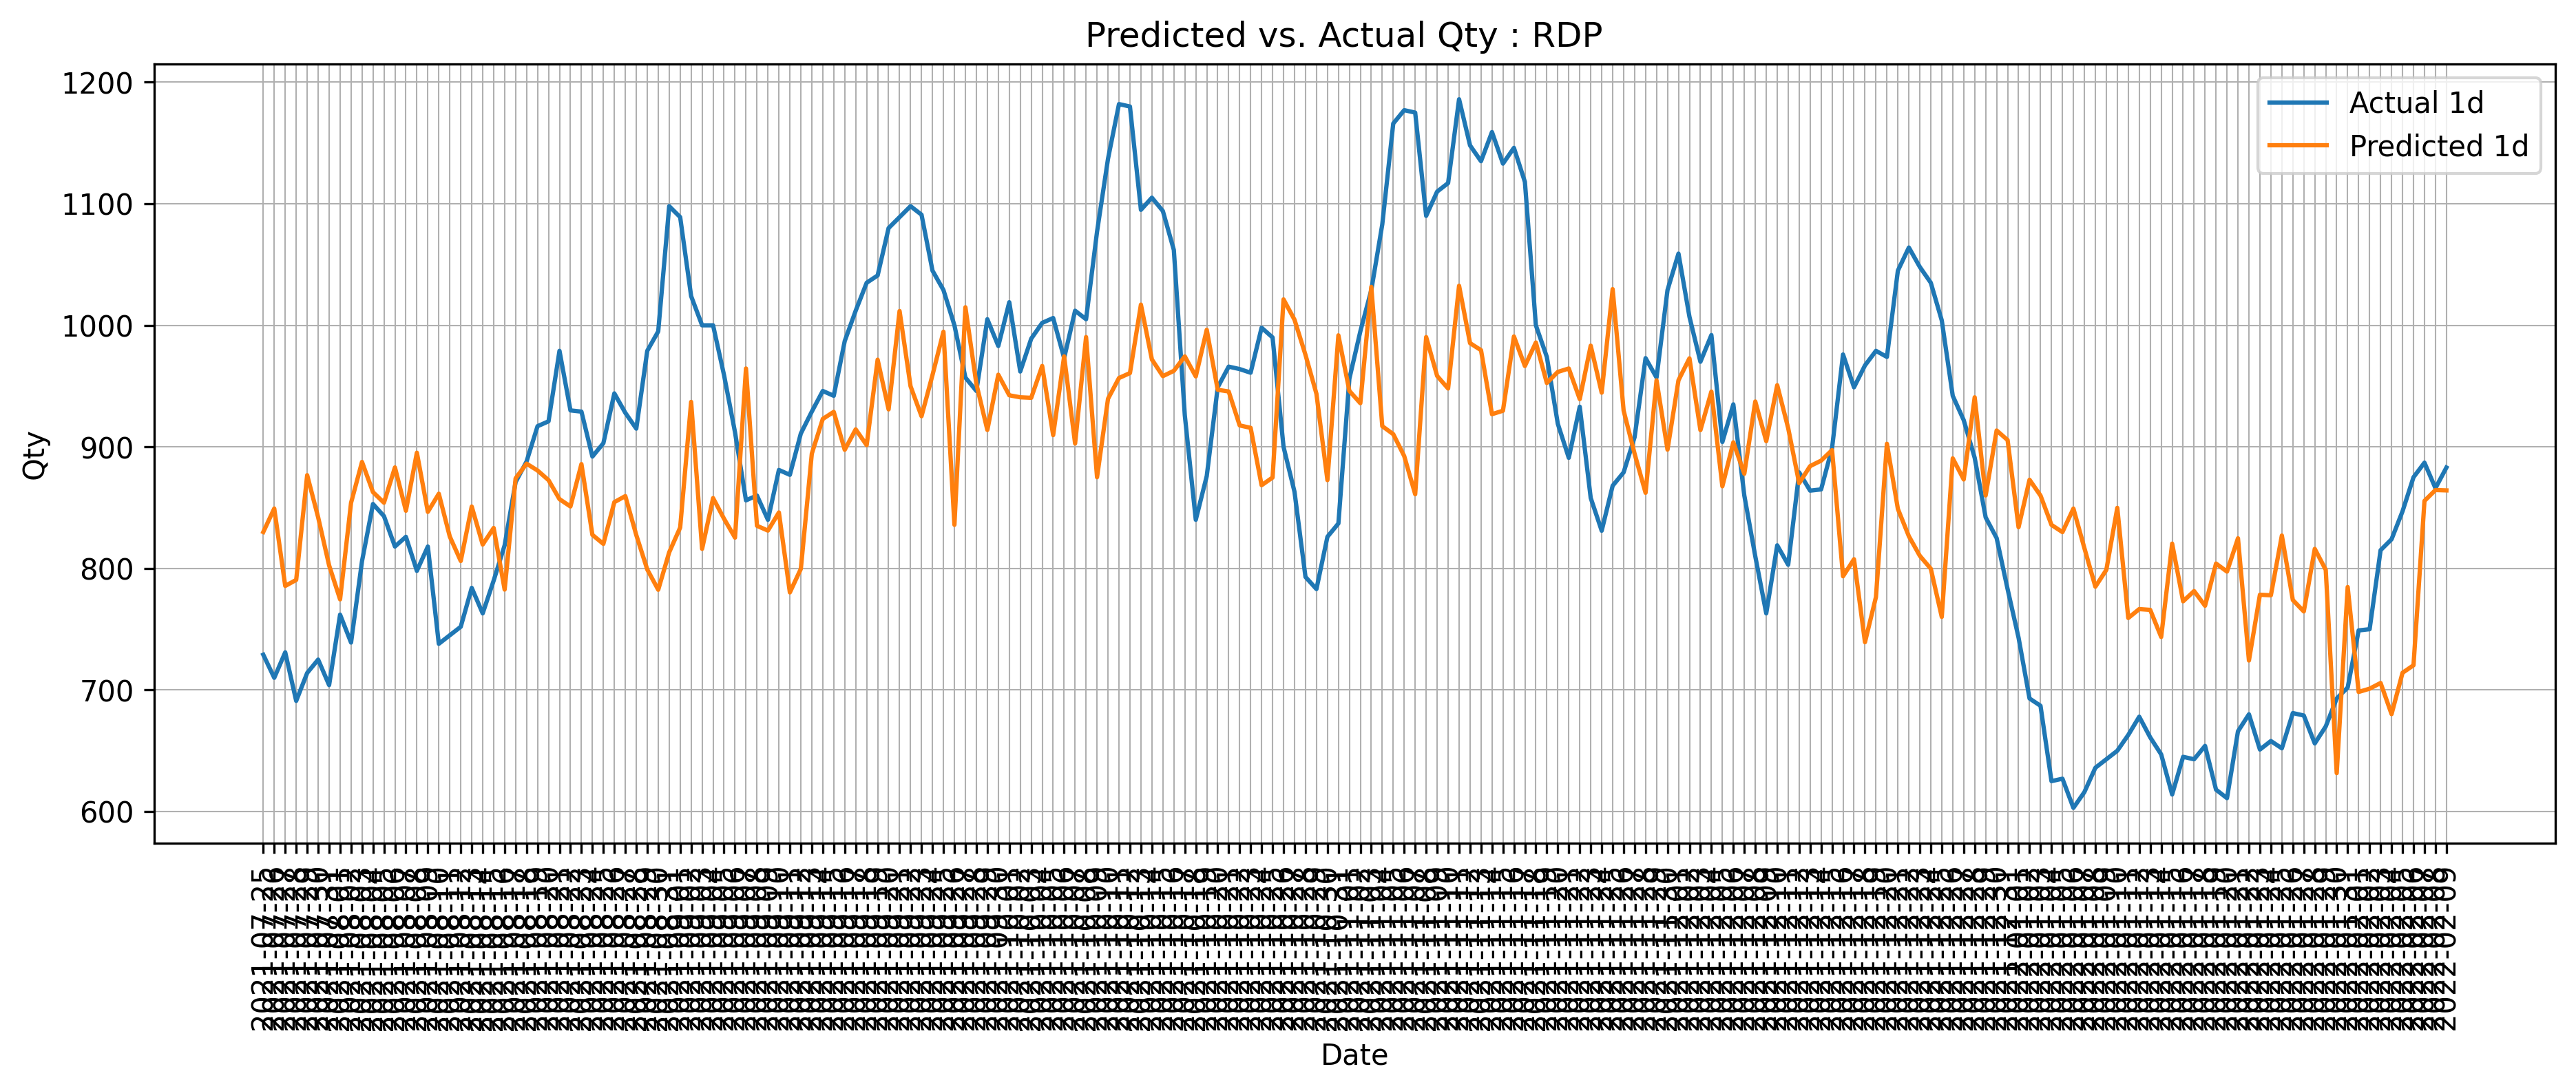

In [25]:
bc = 'RDP'
bg = 'B +ve'
pred_3_weeks = my_model_21d(bc,bg)
print(f"Blood demand for the combination ({bc},{bg}) in next 21 days = {pred_3_weeks}")

## Verifying the seasonlaity

In [20]:
df['weekday'] = df['REQDT'].dt.weekday

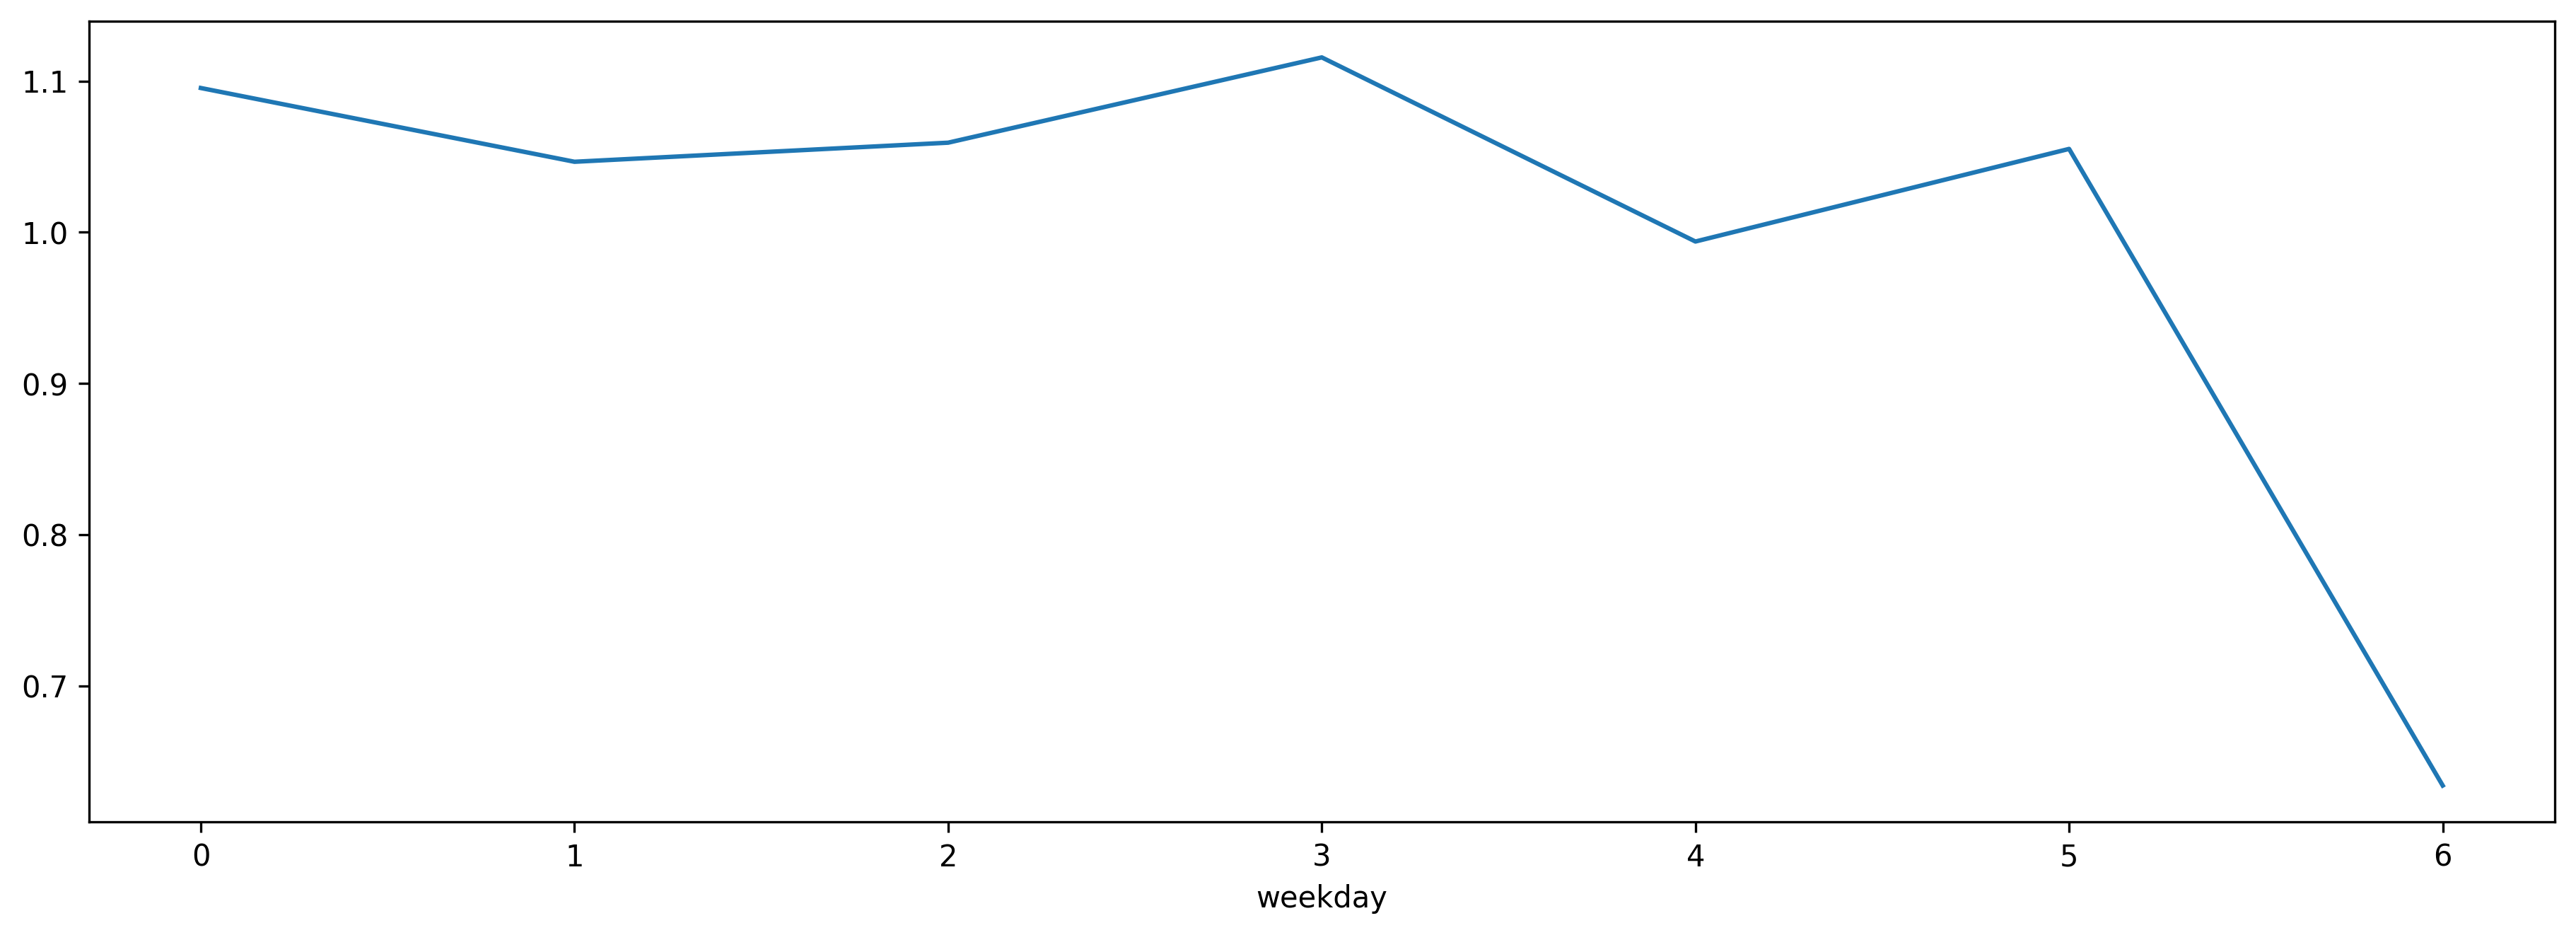

In [21]:
(df.groupby('weekday').QTY.sum()/df.groupby('weekday').QTY.sum().mean()).plot()

In [22]:
(df.groupby('weekday').QTY.sum()/df.groupby('weekday').QTY.sum().mean())

weekday
0    1.095367
1    1.046604
2    1.059225
3    1.115614
4    0.993880
5    1.055111
6    0.634198
Name: QTY, dtype: float64

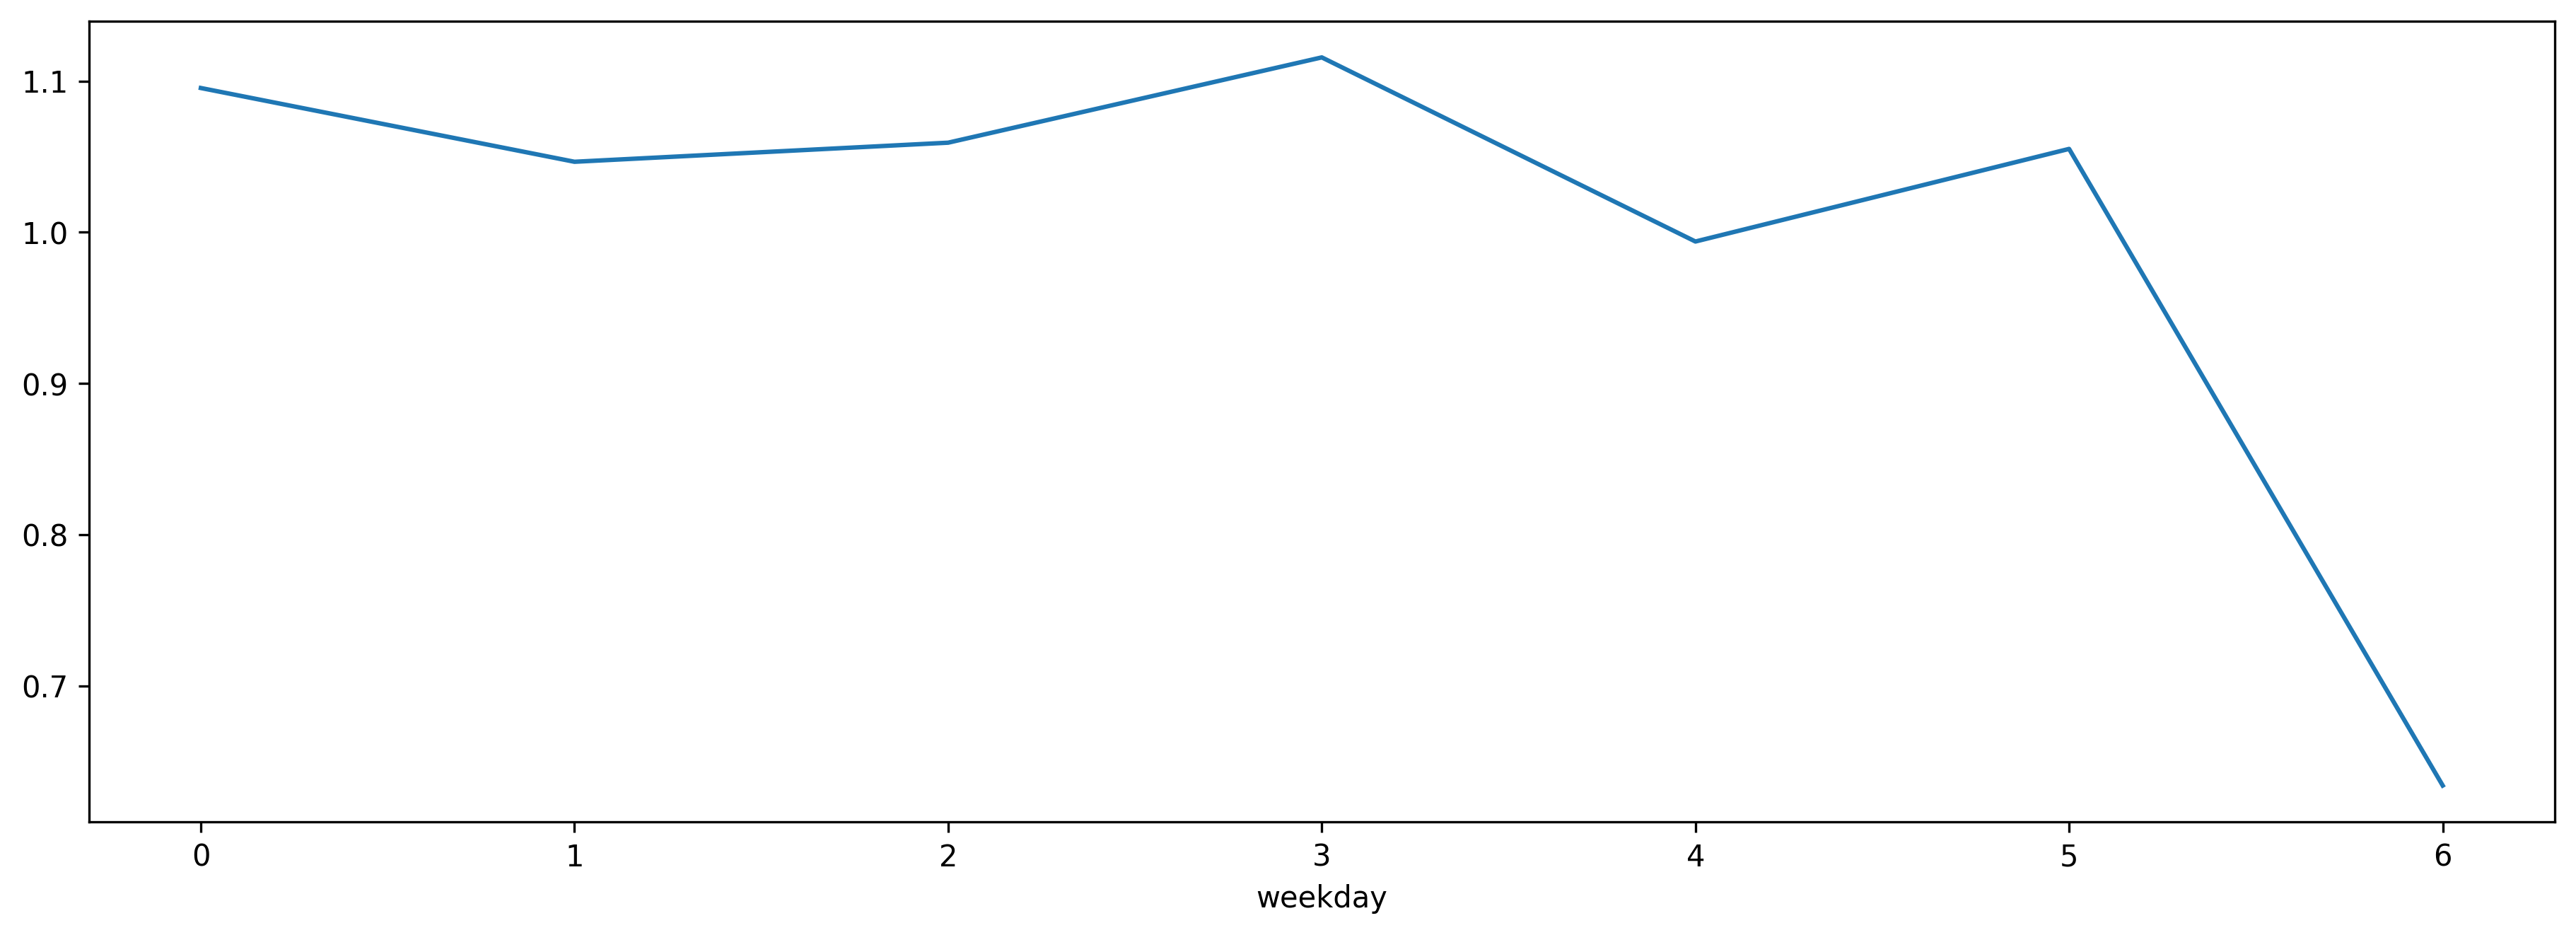

In [23]:
(df.groupby('weekday').QTY.sum()/df.groupby('weekday').QTY.sum().mean()).plot()